# Section 4.2.1 Additive Noise Models

This notebook contains experiments related to section 4.2.1.

Import the first dataset from [the cause-effect metabase](https://webdav.tuebingen.mpg.de/cause-effect/).

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../lib")
from hsic import hsic_gam

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('../data/pair0001.txt', sep=" ", header=None)
data.columns = ["altitude", "temperature"]
data.head()

,altitude,temperature
0,205.0,9.7
1,46.0,8.2
2,794.0,6.4
3,325.0,8.1
4,500.0,6.2


In [5]:
data.describe()

,altitude,temperature
count,349.000000,349.000000
mean,332.470201,8.041547
std,339.297625,1.518514
min,0.000000,-4.800000
25%,70.000000,7.500000
50%,255.000000,8.300000
75%,490.000000,8.900000
max,2960.000000,10.800000


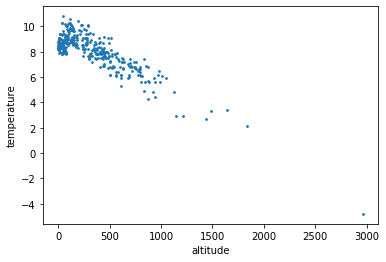

In [6]:
data.plot.scatter(x='altitude', y='temperature', s=3)

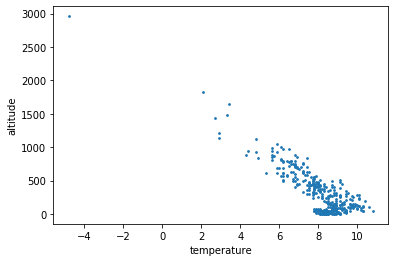

In [7]:
data.plot.scatter(x='temperature', y='altitude', s=3)

## Independence of Residuals Test

_a special case of the regression with subsequent independence test (RESIT)_

In [8]:
from sklearn import datasets, linear_model

In [9]:
length = len(data)
length

349

In [10]:
x = data['altitude'].values.reshape(length, 1)
y = data['temperature'].values.reshape(length, 1)

### 1. Regress $Y$ on $X$

/usr/local/anaconda3/envs/zalon_dev/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


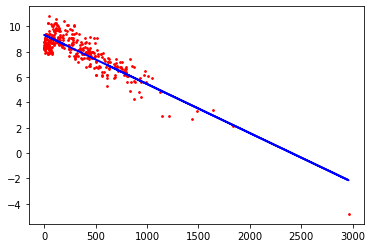

In [11]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y, color='red', s=3)
plt.plot(x, regr.predict(x), color='blue', linewidth=2)
plt.show()

### 2. Test whether $Y-\hat{f}_Y(X)$ is independent of X

Compute residuals

In [12]:
residuals = y - regr.predict(x)

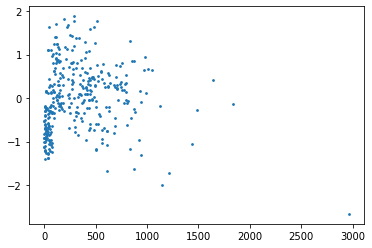

In [13]:
plt.scatter(x, residuals, s=3)

Test independence.
The independence test is [_not easy_](https://stats.stackexchange.com/questions/73646/how-do-i-test-that-two-continuous-variables-are-independent).

In [14]:
from sklearn.feature_selection import mutual_info_regression

In [15]:
info_xtoy = mutual_info_regression(x, residuals.reshape(length))

In [16]:
mutual_info_regression(residuals, x.reshape(length))

array([0.22077278])

Hilbert-Schmidt Independence Criterion (HSIC)

In [17]:
hsic_gam(x.reshape(length, 1), residuals.reshape(length, 1), alph=0.05)

(3.3902079474451403, 0.596093995981436)

### 3. Repeat the procedure with exchanging the roles of $X$ and $Y$

In [18]:
tmp = x
x = y
y = tmp

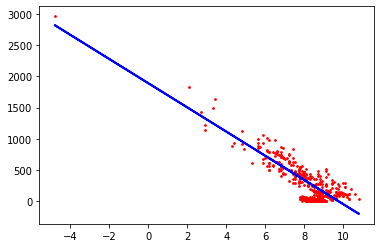

In [19]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

plt.scatter(x, y, color='red', s=3)
plt.plot(x, regr.predict(x), color='blue', linewidth=2)
plt.show()

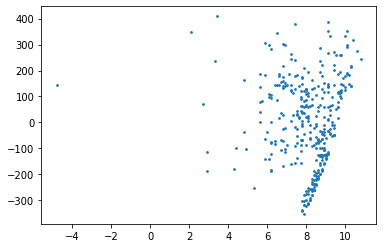

In [20]:
residuals = y - regr.predict(x)
plt.scatter(x, residuals, s=3)

In [21]:
info_ytox = mutual_info_regression(x, residuals.reshape(length))

Hilbert-Schmidt Independence Criterion (HSIC)

In [22]:
hsic_gam(x.reshape(length, 1), residuals.reshape(length, 1), alph=0.05)

(3.9676444003176767, 0.57294680829)

In [23]:
mutual_info_regression(residuals, x.reshape(length))

array([0.47063541])

### 4. Infer the causal direction

In [24]:
info_ytox

array([0.4580875])

In [25]:
info_xtoy

array([0.21998997])

The mutual information of $Y$ (temperature) on the residuals of the regression of $X$ on $Y$ is greater than it is for the other direction (information of $X$ (altitude) on the residuals of the regression of $Y$ on $X$). It can therefore be said that the independence is accepted for one direction $Y$ on $X$ and rejected for the other. The infered causal direction is therefore $X\rightarrow Y$.

## Further Ideas

* It should be clarified whether the way of computing the independence (mutual information) is the best one to choose.
* Other, better fitting features could be chosen for the linear regression, e.g. higher polynomials.
* More datasets, also generated ones, could be experimented with.

## Maximum Likelihood-based Approach

Reproducing Figure 4.5 to interpret Equation 4.18 and Equation 4.19.

In [26]:
n = 1000
x = np.random.uniform(-1, 2, n)
n_y = np.random.uniform(-.5, .5, n)
y = x/2 + n_y

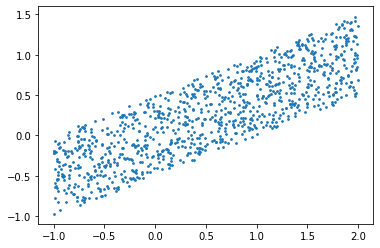

In [27]:
plt.scatter(x, y, s=3)

In [28]:
regr_yonx = linear_model.LinearRegression()
regr_yonx.fit(x.reshape((-1, 1)), y)

regr_xony = linear_model.LinearRegression()
regr_xony.fit(y.reshape((-1, 1)), x)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

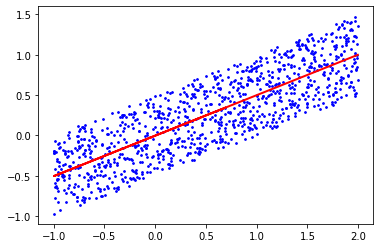

In [29]:
plt.scatter(x, y, color='blue', s=3)
plt.plot(x, regr_yonx.predict(x.reshape((-1, 1))), color='red', linewidth=2)
plt.show()

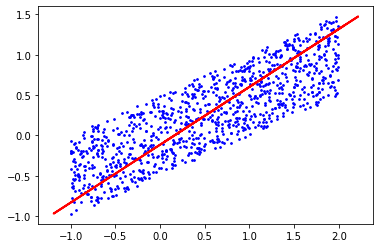

In [30]:
plt.scatter(x, y, color='blue', s=3)
plt.plot(regr_xony.predict(y.reshape((-1, 1))), y, color='red', linewidth=2)
plt.show()

Residuals $R_Y$ and $R_X$

In [31]:
r_y = y - regr_yonx.predict(x.reshape((-1, 1)))
r_x = x - regr_xony.predict(y.reshape((-1, 1)))

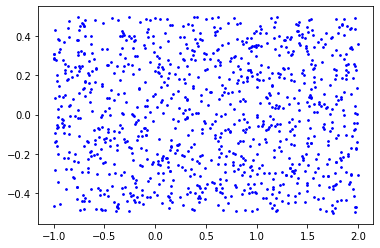

In [32]:
plt.scatter(x, r_y, color='blue', s=3)

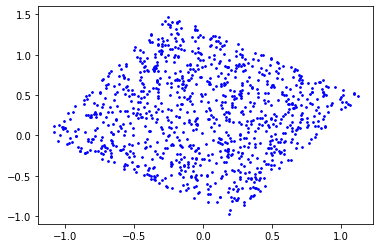

In [33]:
plt.scatter(r_x, y, color='blue', s=3)

### Equations 4.18 and 4.19

$$L_{X\rightarrow Y}=-\log\hat{\text{var}}\left[X\right]-\log\hat{\text{var}}\left[R_Y\right]$$

In [34]:
var_x = np.var(x)
var_ry = np.var(r_y)

In [35]:
var_x, var_ry

(0.759517109714309, 0.08199200594175766)

In [36]:
l_xtoy = -np.log(var_x) - np.log(var_ry)
l_xtoy

2.7762059545826236

And into the other direction

In [37]:
var_y = np.var(y)
var_rx = np.var(r_x)

In [38]:
var_y, var_rx

(0.27323157866069026, 0.2279177673306091)

In [39]:
l_ytox = -np.log(var_rx) - np.log(var_y)
l_ytox

2.776205954582624

Weirdly, $L_{X\rightarrow Y}=L_{Y\rightarrow X}$ in the example above. It is unclear why.